In [29]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from torch_geometric.nn import GCNConv, BatchNorm, global_mean_pool
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
graphs_json = "github_stargazers/git_edges.json" 
labels_csv = "github_stargazers/git_target.csv" 

with open(graphs_json, 'r') as f:
    graphs = json.load(f)

labels_df = pd.read_csv(labels_csv) 


In [4]:
fixed_dim = 16 

data_list = []
for idx, edges in graphs.items():
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    num_nodes = edge_index.max().item() + 1  
    x = torch.ones((num_nodes, fixed_dim)) 

    label = labels_df.loc[labels_df['id'] == int(idx), 'target'].values[0]
    y = torch.tensor([label], dtype=torch.long)

    data = Data(x=x, edge_index=edge_index, y=y)
    data_list.append(data)

train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True) 
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [5]:
from torch_geometric.nn import SAGEConv, global_max_pool, global_add_pool

In [71]:
class BasicGNNClassifier(torch.nn.Module):
    def __init__(self, input_dim=16):
        super(BasicGNNClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, 128)
        self.bn1 = BatchNorm(128)
        self.conv2 = GCNConv(128, 64)
        self.bn2 = BatchNorm(64)
        self.conv3 = GCNConv(64, 32)
        self.bn3 = BatchNorm(32)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.fc = torch.nn.Linear(32, 2) 

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.conv3(x, edge_index)))
        x = self.dropout(x)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x

In [72]:
class SageGNNClassifier(torch.nn.Module):
    def __init__(self, input_dim=16):
        super(SageGNNClassifier, self).__init__()
        self.conv1 = SAGEConv(input_dim, 64)
        self.conv2 = SAGEConv(64, 128)
        self.conv3 = SAGEConv(128, 128)
        self.conv4 = SAGEConv(128, 64)

        self.fc1 = torch.nn.Linear(384, 32)
        self.fc2 = torch.nn.Linear(32, 2)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x1 = F.relu(self.conv1(x, edge_index))
        x2 = F.relu(self.conv2(x1, edge_index))
        x3 = F.relu(self.conv3(x2, edge_index))
        x4 = F.relu(self.conv4(x3, edge_index))

        pool1 = global_mean_pool(x1, batch)
        pool2 = global_max_pool(x2, batch)
        pool3 = global_add_pool(x3, batch)
        pool4 = global_add_pool(x4, batch)
        
        x = torch.cat([pool1, pool2, pool3, pool4], dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [65]:
def train_model(model, train_loader, optimizer, criterion, device, epochs=30, clip_grad=False, max_norm=1.0):
    model.train()
    training_loss = []
    for epoch in range(epochs):
        total_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            loss.backward()
            if clip_grad:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        training_loss.append(avg_loss)
        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")
    return training_loss


In [66]:
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            y_true.extend(data.y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    return accuracy, f1

In [67]:
def run_pipeline(model_class, train_loader, test_loader, device, lr=0.0005, weight_decay=5e-4, epochs=30, input_dim=None, clip_grad=False):
    if input_dim:  # Check if input_dim is required for the model
        model = model_class(input_dim=input_dim).to(device)
    else:
        model = model_class().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    print("Training the model...")
    training_loss = train_model(model, train_loader, optimizer, criterion, device, epochs, clip_grad=clip_grad)

    print("Evaluating the model...")
    accuracy, f1 = evaluate_model(model, test_loader, device)
    return model, accuracy, f1, training_loss

In [68]:
def plot_training_curve(training_loss, title="Training Curve"):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(training_loss) + 1), training_loss, marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.grid()
    plt.show()


In [73]:
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Running BasicGNNClassifier...")
    model, accuracy, f1, training_loss = run_pipeline(BasicGNNClassifier, train_loader, test_loader, device, clip_grad=False, epochs = 50)
    print("BasicGNNClassifier completed.")
    

Running BasicGNNClassifier...
Training the model...
Epoch 1, Loss: 0.6930
Epoch 2, Loss: 0.6871
Epoch 3, Loss: 0.6858
Epoch 4, Loss: 0.6830
Epoch 5, Loss: 0.6835
Epoch 6, Loss: 0.6800
Epoch 7, Loss: 0.6783
Epoch 8, Loss: 0.6781
Epoch 9, Loss: 0.6763
Epoch 10, Loss: 0.6769
Epoch 11, Loss: 0.6762
Epoch 12, Loss: 0.6760
Epoch 13, Loss: 0.6726
Epoch 14, Loss: 0.6739
Epoch 15, Loss: 0.6711
Epoch 16, Loss: 0.6711
Epoch 17, Loss: 0.6704
Epoch 18, Loss: 0.6710
Epoch 19, Loss: 0.6702
Epoch 20, Loss: 0.6665
Epoch 21, Loss: 0.6670
Epoch 22, Loss: 0.6645
Epoch 23, Loss: 0.6656
Epoch 24, Loss: 0.6638
Epoch 25, Loss: 0.6625
Epoch 26, Loss: 0.6632
Epoch 27, Loss: 0.6611
Epoch 28, Loss: 0.6587
Epoch 29, Loss: 0.6576
Epoch 30, Loss: 0.6562
Epoch 31, Loss: 0.6563
Epoch 32, Loss: 0.6550
Epoch 33, Loss: 0.6535
Epoch 34, Loss: 0.6548
Epoch 35, Loss: 0.6533
Epoch 36, Loss: 0.6542
Epoch 37, Loss: 0.6503
Epoch 38, Loss: 0.6518
Epoch 39, Loss: 0.6481
Epoch 40, Loss: 0.6485
Epoch 41, Loss: 0.6497
Epoch 42, Loss

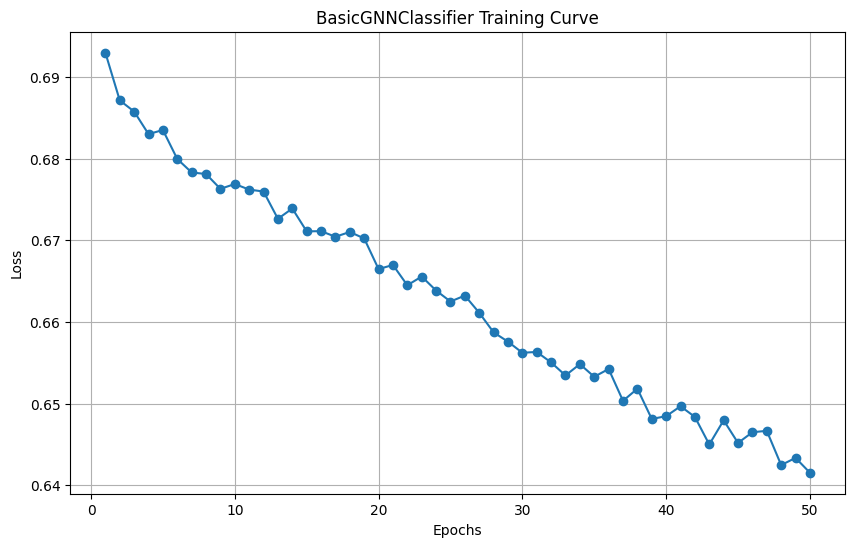

In [74]:
plot_training_curve(training_loss, title="BasicGNNClassifier Training Curve")

In [75]:
print("Running SageGNNClassifier...")
model, accuracy, f1, training_loss = run_pipeline(SageGNNClassifier, train_loader, test_loader, device, clip_grad=True, epochs = 50)
print("SageGNNClassifier completed.")

Running SageGNNClassifier...
Training the model...
Epoch 1, Loss: 0.7310
Epoch 2, Loss: 0.6673
Epoch 3, Loss: 0.6504
Epoch 4, Loss: 0.6455
Epoch 5, Loss: 0.6392
Epoch 6, Loss: 0.6399
Epoch 7, Loss: 0.6366
Epoch 8, Loss: 0.6282
Epoch 9, Loss: 0.6332
Epoch 10, Loss: 0.6310
Epoch 11, Loss: 0.6294
Epoch 12, Loss: 0.6287
Epoch 13, Loss: 0.6274
Epoch 14, Loss: 0.6267
Epoch 15, Loss: 0.6245
Epoch 16, Loss: 0.6217
Epoch 17, Loss: 0.6257
Epoch 18, Loss: 0.6269
Epoch 19, Loss: 0.6278
Epoch 20, Loss: 0.6233
Epoch 21, Loss: 0.6212
Epoch 22, Loss: 0.6221
Epoch 23, Loss: 0.6236
Epoch 24, Loss: 0.6165
Epoch 25, Loss: 0.6186
Epoch 26, Loss: 0.6212
Epoch 27, Loss: 0.6192
Epoch 28, Loss: 0.6188
Epoch 29, Loss: 0.6168
Epoch 30, Loss: 0.6180
Epoch 31, Loss: 0.6180
Epoch 32, Loss: 0.6181
Epoch 33, Loss: 0.6138
Epoch 34, Loss: 0.6164
Epoch 35, Loss: 0.6211
Epoch 36, Loss: 0.6167
Epoch 37, Loss: 0.6156
Epoch 38, Loss: 0.6168
Epoch 39, Loss: 0.6118
Epoch 40, Loss: 0.6100
Epoch 41, Loss: 0.6090
Epoch 42, Loss:

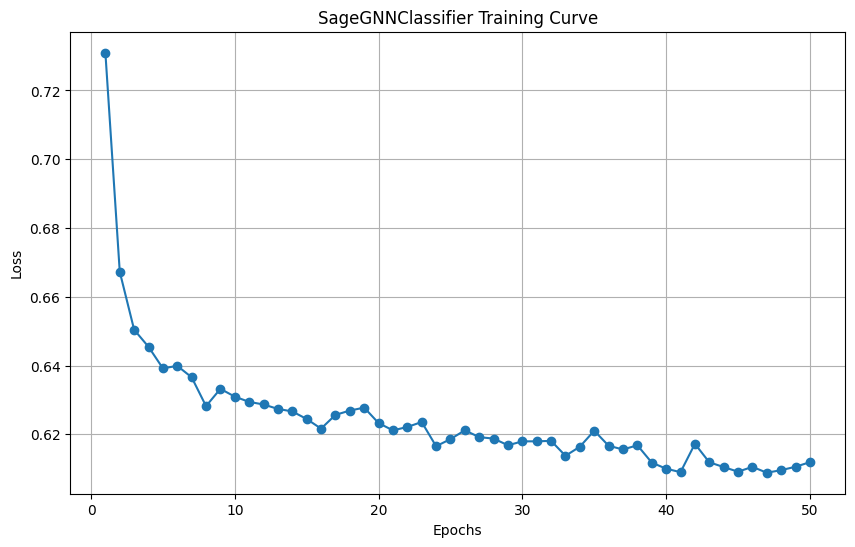

In [76]:
plot_training_curve(training_loss, title="SageGNNClassifier Training Curve")